# Advent of Code

In [1]:
from matplotlib import pyplot as plt, animation
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

import numpy as np
from IPython.display import YouTubeVideo


%matplotlib notebook

Advent of Code je kombinacija adventskih kalendara i programskih zadataka. :)
U vrijeme adventa (tocnije 1.12 - 25.12), na stranici *[adventofcode.com](https://adventofcode.com)* se objavljuje programski zadatak, tocno kao adventski kalendari (ali bez cokoladica :( ). Svaki zadatak otkriva dio slicice za tu godinu. Svaka godina ima smijesnu pricu sa vilenjakom koji spasava Bozic od svakakvih opasnosti i sa svakim zadatkom mi pomazemo vilenjaku.
Advent of Code je veoma koristan za ucenje novog jezika, ucenje struktura podataka i algoritama, pripreme za intervjue.

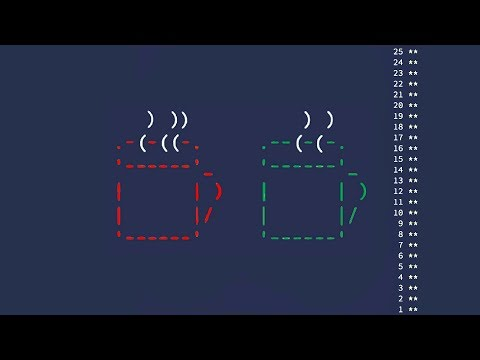

In [2]:
YouTubeVideo('CFWuwNDOnIo', width=800, height=300)

Definitivno preporucam da pogledate video u kojem tvorac Advent of Code-a bolje objasnjava sto je advent of code i kako je nastao.

U ovom eseju cu rijesiti nekoliko zadataka iz Advent of Code-a za koje mislim da su zabavni i koji bi mogli biti veoma korisni za nekog tko nije probao rijesit ovakvu vrstu zadataka.

## Generalne upute

### Rjesenja zadataka

Advent of Code zadatci zahtjevaju nekakav login da bi se rjesenja zadataka mogla potvrditi. Preporucam da napravite svoj account i pokusate rijesiti neke zadatke. Ako to ne zelite, u file-u creds.txt postoji gmail account i password sa kojim se mozete ulogirati i provijeriti zadatke.

### Upute za preuzimanje zadataka

Posjetiti stranicu *[Advent of Code](https://adventofcode.com)*. Na toj stranici napraviti acconut (moze se koristiti github/email) i kopirati svoj session. Pozvati fju `get_aoc_input` sa `session_str` jednakim session-u i danom i godinom zadatka.

Za naci session morate: otvoriti advent of code, desni klik -> inspect, otvoriti karticu `Storage`, kliknuti `Cookies` i kopirati string koji se nalazi u polju session.

### Animacije

U ovom notebook-u imam dvije animacije. Ne mogu se vrtiti obije u isto vrijeme, tako da ako pokrenete `Run All`, morat ce te rucno pokrenut prvu animaciju (nalazi se u odjeljku `Smoke basin`), pa onda rucno pokrenuti drugu animaciju (zadnja slicica u notebook-u).

In [3]:
session = '53616c7465645f5fa84cdf4fd1e667823de36970c380c49a1373a1ac0d5a4ddf77aeb87eda22f992bac9a4e24fa8295f06c385916e074b59f6ba4ee8e53b2612'

In [4]:
import requests
import os

def get_aoc_input(session_str, day, year, return_output=False):
    
    if os.path.exists(f'./{year}_{day}_input.txt'):
        with open(f'{year}_{day}_input.txt') as f:
            text = [x.strip() for x in f.readlines()]
        if return_output: return text
    else:
        response = requests.get(
            f'https://adventofcode.com/{year}/day/{day}/input',
            headers={'cookie':f'session={session_str}'}
        )
    
        try:
            with open(f'{year}_{day}_input.txt', 'w') as f:
                f.write(response.text.strip())
            if return_output: return [x.strip() for x in response.text.strip().split('\n')]
        except Exception as e:
            print(f'Error: {e.args}')
            return None

## Lanternfish

*[Link na zadatak](https://adventofcode.com/2021/day/6)*

Ajmo rijesit nesto relativno jednostavno kao prvi zadatak :).
Evo tldr ako niste procitali zadatak sa stranice.
Imamo neke ribice i neka pravila kako nastaju nove ribice. Svaka ribica ima timer koji pokazuje koliko iteracija treba da bi nova ribica nastala iz trenutne. Input nam je lista brojeva koja predstavlja ribice i koliko vremena imaju do dupliciranja. Nakon dupliciranja, novoj ribici se timer postavlja na 8, a staroj na 6. Mi trebamo izracunati koliko ribica imamo nakon 80 iteracija.

In [5]:
from collections import deque
import re
import itertools as it

In [6]:
get_aoc_input(session, 6, 2021)

Razmislimo sto se trazi od nas. Imamo niz brojeva koji predstavljaju ribice. Trebaju nam dva niza, jedan sa trenutnom generacijom i jedan sa novom generacijom. Svaki put kada broj dode do 0, dodajemo novu ribicu u niz sa novom generacijom (sa brojem 8), a trenutnu ribicu stavljamo na 6 u trenutnom nizu. Nakon svake iteracije spojimo dva niza. To napravimo 80 puta i gotov zadatak.

In [7]:
with open('2021_6_input.txt') as f:
    inlist = list(map(int, f.readline().strip().split(',')))
for _ in range(80):
    new_gen = []
    for i,num in enumerate(inlist):
        if num == 0:
            inlist[i] = 6
            new_gen.append(8)
        else:
            inlist[i] -= 1
    inlist += new_gen
print(len(inlist))

362346


Veoma jednostavno :)

Sidenote za one koji nisu pogledali video. U adventu svaki zadatak ima 2 podzadatka. Obicno vrijedi da se u prvom zadatku implementira dio funkcionalnosti, a u drugom se koristi ili modificira prvi dio zadatka. Nekada se zna dogoditi (foreshadowing) da postoji konkretna ideja na koju autor zadatka cilja i nerijetko se dogodi da se prvi podzadatak mora reimplementirati nakon sto se procita drugi podzadatak.

Paaa, ajmo procitat drugi podzadatak.

```
Suppose the lanternfish live forever and have unlimited food and space. Would they take over the entire ocean?

After 256 days in the example above, there would be a total of *26984457539* lanternfish!

How many lanternfish would there be after *256* days?
```

Ajoj.......

Ocito smo propustili tekst na pocetku zadatka u kojem je bila boldana rijec exponentially...
Ako pokusamo samo promijeniti 80 u 258 i pokrenemo, necemo vidjeti ikakvo rjesenje.

Ideja na koju se cilja u ovom zadatku zove se *[memoizacija](https://en.wikipedia.org/wiki/Memoization)*. 
Dio koji nam je promakao u razmisljanju za prvi podzadatak je da znamo da postoji samo 8 stanja. Puno jednostavnije je onda imati niz sa 8 celija. Svaka celija sadrzi broj ribica koji se nalazi u tom stanju. Iteriranje nam je prebacivanje brojeva iz celije u celiju i vise nemamo problema sa rijeci exponentially

### Rjesenje pomocu numpy-a

In [8]:
lines = np.loadtxt('2021_6_input.txt', delimiter=',', dtype="uint32")
fish_timer = np.zeros(9)
time, count = np.unique(lines, return_counts=True)
fish_timer[time] = count

In [9]:
def memoize_numpy(fish_timer, days):
    gen = np.copy(fish_timer)
    for _ in range(days):
        gen[7] += gen[0]
        gen = np.roll(gen, -1)
    return sum(gen)

In [10]:
print(memoize_numpy(fish_timer, 80))
print(memoize_numpy(fish_timer, 256))

362346.0
1639643057051.0


<IPython.core.display.Javascript object>


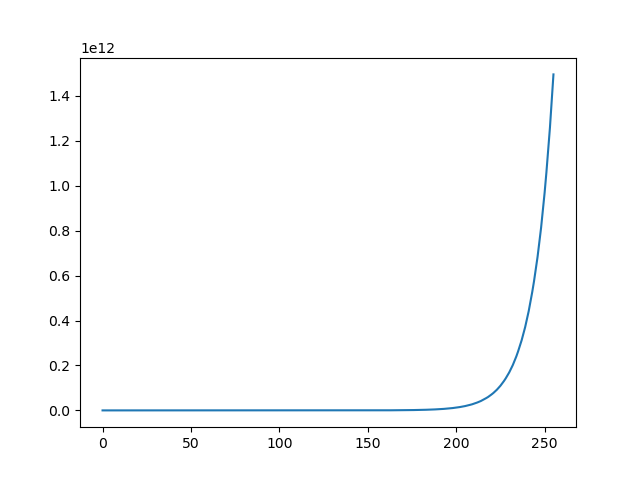

In [11]:
def generator(fish_timer, days):
    for i in range(days):
        yield memoize_numpy(fish_timer, i)

y = [x for x in generator(fish_timer, 256)]

fig, ax = plt.subplots()
ax.plot(y)
plt.show()

Ovaj brzi rast oko ~200 je onaj 'Ajoj.....' nakon citanja drugog podzadatka

### Rjesenje pomocu vulgaris python-a :)

(Jer ja volim vulgaris python)

In [12]:
with open('2021_6_input.txt') as f:
    inlist = list(map(int, f.readline().strip().split(',')))
d = deque([0 for _ in range(9)])
for num in inlist:
    d[num] += 1

In [13]:
def memoize_pure_python(deq, days):
    d = deque([x for x in deq])
    for _ in range(days):
        d[7] += d[0]
        d.rotate(-1)
    return sum(d)

In [14]:
print(memoize_pure_python(d, 80))
print(memoize_pure_python(d, 256))

362346
1639643057051


## Experimental Emergency Teleportation
*[Link na zadatak](https://adventofcode.com/2018/day/23)*

Ovo se naizgled cini kao relativno jednostavan zadatak. Imamo ulazne podatke zapisane u lijepom formatu (regex ftw :), proparsiramo ih, napravimo duplu petlju po svim tockama i pamtimo informaciju o koliko tocaka ima u radiusu. Ez :).

In [15]:
import re
from collections import Counter

def parse_line(line):
    return tuple(map(int, re.match(r'pos=<(-?\d+),(-?\d+),(-?\d+)>, r=(\d+)', line).groups()))

def manh_dist(point1, point2):
    return sum(abs(point1[i] - point2[i]) for i in range(3))

inlist = get_aoc_input(session, 23, 2018, return_output=True)
inputs = [parse_line(line) for line in inlist]
c = Counter()
for n1 in inputs:
    for n2 in inputs:
        if manh_dist(n1,n2) <= n1[-1]:
            c[n1] += manh_dist(n1,n2) <= n1[-1]

n = sorted(c.keys(), key=lambda x: x[-1], reverse=True)[0]
print(c[n])

420


Iznad sam napravio tocno ono sto sam opisao, `Counter` iz `collections` paketa tu lijepo posluze.

Drugi dio zadatka je vec problem :(
Ono sto nas autor zadatka trazi je nac tocku (ne samo iz liste tocaka iz inputa, vec u cijelom prostoru) koja se nalazi u radiusu najvise nanobota. 
Ako je netko bacio oko na input podatke, vidio bi nesto tipa:
```
pos=<103290942,42471093,43305198>, r=97952018
pos=<-9203818,54725315,72095008>, r=58880343
```
Ovakvih koordinata ima tocno 1000. Po uputama zadatka, mi se nalazimo na poziciji `(0,0,0)`. Kratka matematika nam kaze da ovo ne mozemo racunat za svaku tocku u koordinatnom sustavu. Moramo raditi nesto tipa divide and conquer ili nekakvo binarno pretrazivanje. Tko zeli neka pokusa, al meni je to malo prekomplicirano :), ovo mozemo rijesiti na jednostavniji nacin.

Ovo je dobro vrijeme da predstavim jedan predivan python paket koji se zove `z3-solver` *[github](https://github.com/Z3Prover/z3)*. Za onog koga vise zanima, moze pratiti linkove po github-u, za one koje ne zanima, z3 je SMT (Satisfiability Modulo Theories) solver. Ono sto to nama, konkretno za ovaj problem, znaci je da mi mozemo reci solveru sto mi trazimo, koje uvijete to treba zadovoljit i koji su podatci (input). Nakon toga mu kazemo "daj mi nadi tocku koja to zadovoljava ako takva tocka postoji" i tjt.

In [16]:
from z3 import *

def zabs(x):
    return If(x >= 0,x,-x)

(x,y,z) = (Int('x'),Int('y'),Int('z'))
in_ranges = [Int(f'in_range_{i}') for i in range(len(inputs))]
range_count = Int('sum')
dist_from_zero = Int('dist')

o = Optimize()
for i in range(len(inputs)):
    nx,ny,nz,nr = inputs[i]
    o.add(in_ranges[i] == If(zabs(x-nx) + zabs(y-ny) + zabs(z-nz) <= nr, 1, 0))   
o.add(range_count == sum(in_ranges))
o.add(dist_from_zero == zabs(x) + zabs(y) + zabs(z))

Iznad sam rekao solveru sa kakvim podatcima radi, koje su mu varijable. `Optimize` klasu koristim kako bi rijesio problem. U for petlji iznad `nx, ny, nz, nr` su kao konstante solveru, dok su `x,y,z` varijable po kojima ce on pretrazivat.

In [17]:
h1 = o.maximize(range_count)
h2 = o.minimize(dist_from_zero)
print(o.check())
print(o.lower(h2), o.upper(h2))

sat
124276103 124276103


Minimiziramo po udaljenosti od ishodista, maksimiziramo po broju nanobota kojima smo unutar radiusa. Puno jednostavnije od algoritamskog pakla kroz koji bi prosli da smo ovo isli rjesavat bez `z3-solver` paketa.

## Smoke Basin

*[Link na zadatak](https://adventofcode.com/2021/day/9)*

Ovaj zadatak ima neku povrsinu koja je definirana preko matrice brojeva $\{0,\ldots,9\}$ koji predstavljaju neku visinu. Prvi dio zadatka trazi da nademo tzv `low points`. Tocka je `low point` ako je okruzena (gore, dolje, lijevo, desno) sa tockama vece vrijednosti. Mi trebamo naci `risk level` $R$ koji je definiran
$$
R = \sum_{low \in L} low + 1
$$
gdje je $L$ skup svih tocaka koje su `low points`.

In [42]:
inlist = get_aoc_input(session, 9, 2021, return_output=True)
matrix = [[int(x) for x in line] for line in inlist]
matrixes = np.array([[[int(x) for x in line] for line in inlist]])

Ovaj zadatak cu rijesiti tako da cu za svaku tocku u matrici provijeriti dali je ona `low point` i ako je spremit cu ju u listu `lows` (potrebno kasnije) i povecavati `risk_level`.

Funkcija `check_low_spots` provjerava dali je tocka `low_point`. Dodatna ifologija sa `matrix` objektom je za animaciju kasnije.

In [43]:
def check_low_spot(i,j,inlist,matrix):
    ok = True
    for (x,y) in [(1,0), (0,1), (-1,0), (0,-1)]:
        if -1 < y + j < len(inlist) and -1 < x + i < len(line):
            ok &= int(inlist[y+j][x+i]) > int(l)
    if ok:
        matrix[j][i] = 0
        return matrix, 1+int(l)
    else:
        matrix[j][i] = 6 if matrix[j][i] != 9 else 9
        return None, None

In [44]:
lows,risk_level = [],0
for j,line in enumerate(inlist):
    for i,l in enumerate(line):
        m, n = check_low_spot(i,j,inlist,matrix)
        if m is not None:
            risk_level += n
            lows.append((i,j))
            matrixes = np.append(matrixes, [m], axis=0)
print(risk_level)

558


Jos jedan lagani prvi dio zadatka (mislim da mozete uocit neki uzorak tu :). Drugi zadatak uvodi pojam `basin`. `basin` je skup tocaka koje se "slijevaju" u jedan `low point` (tu dolazi lista `lows` u igru) (mislim da je najbolja hrvatska rijec za basin bazen pa cu to koristit dalje). Trebamo naci 3 najveca bazena i vratiti produkt njihovih velicina. Velicina bazena je definirana kao suma svih vrijednosti tocaka koje cine taj bazen (tocke sa brojem 9 nisu dio niti jednog bazena). Vrijedi da je svaka tocka (osim onih sa vrijdnosti 9) dio tocno jednog bazena.

Jako je bitan dio `tocke sa brojem 9 nisu dio niti jednog bazena`. Koristeci tu informaciju i uvjete zadatka, lako se odredi jedan bazen (okruzen je sa tockama vrijednosti 9 i svaka tocka iz liste `lows` je iz jednog bazena). Bazen mozemo odrediti `BFS` algoritmom. *[Link](https://en.wikipedia.org/wiki/Breadth-first_search)* za one koji nisu sigurni sto je `BFS`. Pocetak pretrazivanja su nam tocke iz liste `lows` koje smo nasli u prethodnom zadatku.

In [21]:
def basin_size(x,y,inlist):
    seen = set()
    Q = [(x,y)]
    size = 0
    while len(Q) > 0:
        curr = Q.pop(0)
        curx, cury = curr
        if curr in seen:
            continue
        seen.add(curr)
        if 0 <= cury < len(inlist) and 0 <= curx < len(inlist[0]):
            if int(inlist[cury][curx]) != 9:
                size += 1
                Q += [(curx+1,cury), (curx-1,cury), (curx,cury+1), (curx,cury-1)]
    return size

Proiteriramo po svim tockama iz `lows`, prikupimo velicine bazena i sortiramo ih.

In [22]:
basins = []
for (x,y) in lows:
    basins.append(basin_size(x,y,inlist))
basins.sort()
print(f'Size of the largest three basins: {basins[-1]}, {basins[-2]}, {basins[-3]}')
print(f'Those numbers multiplied: {basins[-1] * basins[-2] * basins[-3]}')

Size of the largest three basins: 101, 94, 93
Those numbers multiplied: 882942


Ovo su samo neke sitnice za animaciju. Iz animacije se lijepo vide svi bazeni i `low points` bazena

<IPython.core.display.Javascript object>


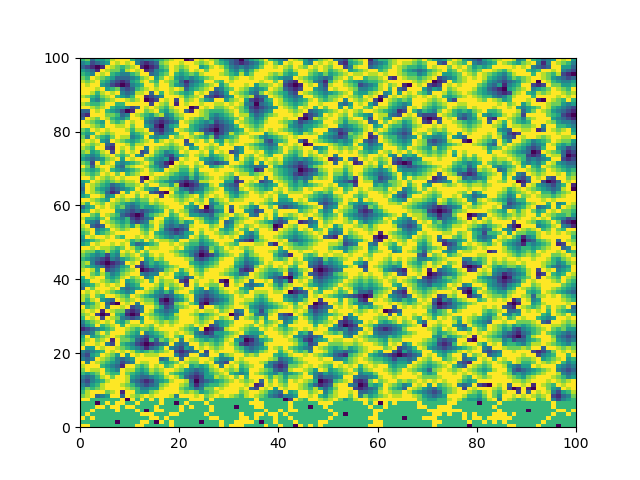

In [45]:
fig, ax = plt.subplots()
cax = ax.pcolormesh(matrixes[0, :, :])

def basin_animate(i):
    cax.set_array(matrixes[i, :, :])
    return cax

anim = animation.FuncAnimation(fig, basin_animate, interval=100, frames=matrixes.shape[0] - 1)
plt.show()

## Jurassic Jigsaw

*[Link na zadatak](https://adventofcode.com/2020/day/20)*

Ovaj zadatak je daleko najtezi zadatak u eseju.... Sretno sa citanjem :)

Input nam je niz matrica sastavljenih od znakova `.` i `#`. Svaka matrica ima svoj `ID`. Matrice predstavljaju puzle koje, jednom kad ih slozimo, ce sadrzavati sliku cudovista. Ove puzle slazemo tako da nademo rubove koji se podudaraju, sa time da kod ovih puzli rubovi moraju biti isti ako se puzle podudaraju. Npr.
```
#  #
.  .
.  .
#  #
```
Ova dva ruba se podudaraju.
Prvi dio zadatka trazi da nademo `ID` rubnih puzli i vratimo njihov produkt.

In [24]:
get_aoc_input(session, 20, 2020)

with open('2020_20_input.txt') as f:
    tiles = {
        int((line := tile.split('\n'))[0].split()[1][:-1]) : np.array([[int(x) for x in y] for y in line[1:]])
        for tile in f.read().replace('.','0').replace('#','1').split('\n\n')
    }

In [25]:
from functools import reduce

edges = {
    k : set.union(*[{tuple(edge), tuple(reversed(edge))} for edge in [v[0], v[-1], v[:,0], v[:,-1]]])
    for k, v in tiles.items()
}
neighbors = {
    k1 : ({k2 for k2, v2 in edges.items() if v1 & v2} - {k1}) for k1,v1 in edges.items()
}
corners = [k for k, v in neighbors.items() if len(v) == 2]

print(reduce(lambda a,b: a * b, corners))

17148689442341


In [26]:
def rotations(tile):
    for _ in range(2):
        for _ in range(4):
            tile = np.rot90(tile)
            yield tile
        tile = np.flip(tile,0)

In [27]:
current = corners[0]
reverse = False
tiles[current] = next(
    tile for tile in rotations(tiles[current]) 
    if {tuple(tile[-1]), tuple(tile[:,-1])}.issubset(
        set.union(*[edges[k] for k in neighbors[current]])
    )
)
chart = []
chart_row = [tiles[current][1:-1,1:-1]]
chart_with_edges = []
chart_row_with_edges = [tiles[current]]

In [28]:
def find_next_tile(current, current_edge, reverse, row):
    next_tile = [k for k in neighbors[current] if tuple(current_edge) in edges[k]]
    if len(next_tile) > 0:
        tiles[next_tile[0]] = [
            tile for tile in rotations(tiles[next_tile[0]]) 
            if tuple(current_edge) == (tuple(tile[:,-int(reverse)]) if row else tuple(tile[0]))
        ][0]
        return next_tile[0]
    return None

In [29]:
def get_next_tile(current, chart, chart_row, cwe, crwe, reverse, row=True):
    next_tile_id = find_next_tile(current, tiles[current][:,-(not reverse)] if row else tiles[current][-1], reverse, row)
    if next_tile_id:
        current = next_tile_id
        chart_row += [tiles[current][1:-1,1:-1]]
        crwe += [tiles[current]]
    else:
        if len(chart_row) == 0: return next_tile_id
        chart += [np.hstack(chart_row)] if not reverse else [np.hstack(chart_row[::-1])]
        cwe += [np.hstack(crwe)] if not reverse else [np.hstack(crwe[::-1])]
        chart_row.clear()
        crwe.clear()
    return next_tile_id

<IPython.core.display.Javascript object>


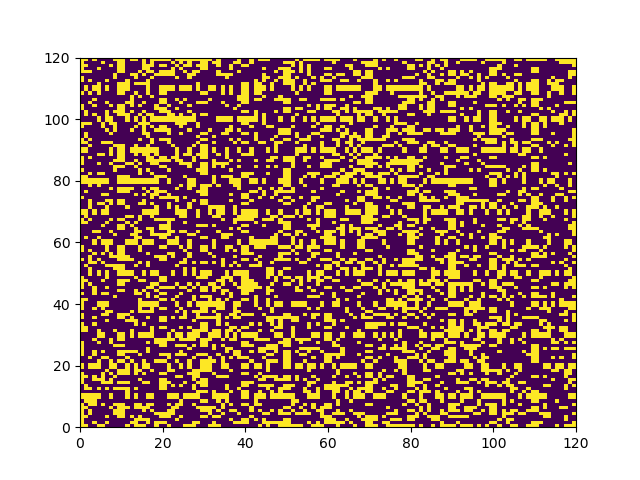

In [30]:
while current:
    next_tile_id = get_next_tile(current, chart, chart_row, chart_with_edges, chart_row_with_edges, reverse)
    if next_tile_id is None:
        reverse = not reverse
        current = get_next_tile(current, chart, chart_row, chart_with_edges, chart_row_with_edges, reverse, row=False)
    else:
        current = next_tile_id
        
chart = np.vstack(chart)
chart_with_edges = np.vstack(chart_with_edges)
fig, ax = plt.subplots()
cax = ax.pcolormesh(chart_with_edges)

In [31]:
nessie = np.array([[int(x) for x in y] for y in ('''
                  # 
#    ##    ##    ###
 #  #  #  #  #  #   
'''.replace(' ', '0').replace('#','1').split('\n')[1:-1])])

def scan(chart, nessie):
    nessies = 0
    for i in range(len(chart) - len(nessie)):
        for j in range(len(chart[0]) - len(nessie[0])):
            area = (chart[i : i + len(nessie), j : j + len(nessie[0])] + nessie)
            if len(area[area == 2]) == 15:
                for k in range(i, i + len(nessie)):
                    for l in range(j, j + len(nessie[0])):
                        if nessie[k - i][l - j] == 1: chart[k][l] = 10
                nessies += 1
    return nessies

29
2009


<IPython.core.display.Javascript object>


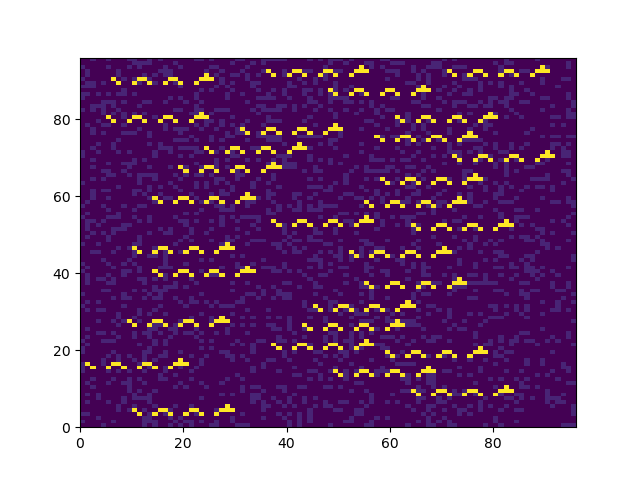

In [32]:
for rot in rotations(chart):
    if (nessies := scan(rot, nessie)) > 0:
        print(nessies)
        print(sum(chart[chart == 1]))
        rot = np.fliplr(np.flip(rot))
        fig, ax = plt.subplots()
        cax = ax.pcolormesh(rot)
        break

# Sea Cucumber

In [33]:
inlist = get_aoc_input(session, 25, 2021, return_output=True)
d, dd = {}, {}
for i,line in enumerate(inlist):
    for j,char in enumerate(line):
        d[(i,j)] = char
dir_map = {'>' : 4, 'v' : 7, '.' : 0}
cucumber_matrix = [[dir_map[x] for x in line] for line in inlist]
move_map = {'>' : (0,1), 'v' : (1,0)}
len_row, len_col = len(inlist), len(inlist[0])

In [34]:
def move_cucumber(direction, d, dd, cucumber_matrix):
    global dir_map, move_map, len_row, len_col
    moved = False
    for i in range(len_row):
        for j in range(len_col):
            k,l = (i + move_map[direction][0]) % len_row, (j + move_map[direction][1]) % len_col
            if d[(i,j)] == direction and d[(k,l)] == '.':
                dd[(i,j)] = '.'
                dd[(k,l)] = direction
                cucumber_matrix[i][j] = 0
                cucumber_matrix[k][l] = dir_map[direction]
                moved = True
    return dd, moved

In [35]:
def next_step(direction, d, dd):
    global matrix_list, cucumber_matrix
    dd = {k:v for k,v in d.items()}
    dd, moved = move_cucumber(direction, d, dd, cucumber_matrix)
    matrix_list = np.append(matrix_list, [cucumber_matrix], axis=0)
    return d, dd, moved

In [36]:
step = 0
matrix_list = np.array([[[dir_map[x] for x in line] for line in inlist]])
while True:
    d, dd, moved = next_step('>', d, dd)
    dd, d, moved2 = next_step('v', dd, d)
    if not moved and not moved2:
        break
    step += 1
print(step + 1)

518


<IPython.core.display.Javascript object>


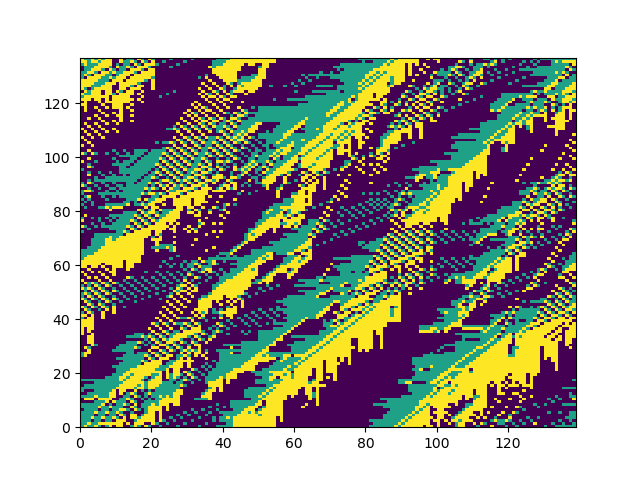

In [39]:
def cucumber_animate(i):
    cax.set_array(matrix_list[i, :, :])
    return cax

fig, ax = plt.subplots()
cax = ax.pcolormesh(matrix_list[0, :, :])

anim = animation.FuncAnimation(fig, cucumber_animate, interval=10, frames=matrix_list.shape[0] - 1)
plt.show()